TODO:

- Add reading other ksizes
- compare "best" tissues across ksizes
- save compiled csv to s3
- if < 2GiB parquet file, save as parquet


# How to be a Bioinformagician part 2
- Author: Olga Botvinnik
- Date: 2018-10-09

Abstract: Many computational problems have already been solved and yet hundreds of hours are lost to re-solving them. This series provides tips and tricks that solve common pain points in bioinformatics, using AWS, reading/writing CSVs, extracting data out of file names, and lots more!

## Prerequisities
1. Everything you do should be full screen. Use [divvy](http://mizage.com/divvy/) to make managing windows easier - ask IT for a license
1. [anaconda python](https://www.anaconda.com/download/#macos) - Install the 3.x (e.g. 3.7) version if you don't have it already
1. aws account - Ask Olga or James for one
1. awscli - on the command line, `pip install awscli` after you install Anaconda Python
1. aegea - on the command line, `conda install aegea` after you install Anaconda Python
1. nbconda - on the command line, `conda install nbconda` after you install Anaconda Python
1. reflow. Click this link: https://github.com/grailbio/reflow/releases/download/reflow0.6.8/reflow0.6.8.darwin.amd64 Then on the command line:
    ```
    cd ~/Downloads
    chmod ugo+x reflow0.6.8.darwin.amd64
    sudo mv reflow0.6.8.darwin.amd64 /usr/local/bin/reflow
    ```
    Now the command `reflow` should output a lot of stuff:
    
    ```
      reflow
    The reflow command helps users run Reflow programs, inspect their
    outputs, and query their statuses.

    The command comprises a set of subcommands; the list of supported
    commands can be obtained by running

        reflow -help

    ... (more stuff) ...
    ```
    Then configure reflow, following the [Confluence entry on Reflow (https://czbiohub.atlassian.net/wiki/spaces/DS/pages/838205454/reflow) instructions for configuration:
    ```
    AWS_SDK_LOAD_CONFIG=1 reflow setup-ec2
    AWS_SDK_LOAD_CONFIG=1 reflow setup-s3-repository czbiohub-reflow-quickstart-cache
    AWS_SDK_LOAD_CONFIG=1 reflow setup-dynamodb-assoc czbiohub-reflow-quickstart
    export AWS_REGION=us-west-2
    ```
1. Claim a folder within `s3://czbiohub-cupcakes/` with today's date and your username, e.g.:
    ```
    s3://czbiohub-cupcakes/2018-10-09/olgabot/
    ```
1. [GitHub](http://github.com) username and membership to [@czbiohub](https://github.com/czbiohub/) GitHub group.

Highly recommended:
- If you haven't seen it already, follow https://github.com/czbiohub/codonboarding
- Especially 
    - install homebrew - it makes your life better for installing packages on mac
    ```
    /usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
    ```
    - install Oh My ZSH: https://ohmyz.sh/
    - Install exa: https://the.exa.website/ - MUCH easier to install if you installed homebrew.
    ```
    brew install exa
    ```


# How to be a bioinformagician, part 2

# Step 1: Launch Jupyter Notebooks from AWS

## 1.01 Use an existing packer image

### YOU can make your own packer image

I get questions about "how can I make my own image?" and people don't realize it's much easier than they think!

- You aren't beholden to what already exists there
- If the README instructions suck, ask me or James questions and we'll try to answer them. We'll also probably tell you to fix the README for future people with the same question
- Look at the [installation script for Jupyter](https://github.com/czbiohub/packer-images/blob/master/scripts/jupyter.sh) - it's super simple. You've already used those commands on AWS so it's not a huge leap to make a packer image.

Here's the `aegea launch` command. You'll want to change the `olgabot` in  `olgabot-cupcakes` to be your own name.


```
aegea launch --ami-tags Name=czbiohub-cupcakes -t t2.micro --security-groups='R/RStudio Server and JupyterHub' --iam-role S3fromEC2 olgabot-cupcakes
```

We're using a tiny instance (`t2.micro` - see [all instance options](https://www.ec2instances.info/)) because it's free and we can just keep it running week-to-week. We don't need a ton of memory, either.



#### Aegea launch errors
If you're getting an error that looks like:

```
 Mon  8 Oct - 10:31  ~ 
  aegea launch --ami-tags Name=czbiohub-jupyter -t t2.micro --security-groups='R/RStudio Server and JupyterHub' --iam-role S3fromEC2 olgabot-cupcakes
Traceback (most recent call last):
  File "/anaconda3/bin/aegea", line 23, in <module>
    aegea.main()
  File "/anaconda3/lib/python3.6/site-packages/aegea/__init__.py", line 78, in main
    result = parsed_args.entry_point(parsed_args)
  File "/anaconda3/lib/python3.6/site-packages/aegea/launch.py", line 50, in launch
    dns_zone = DNSZone(config.dns.get("private_zone"))
  File "/anaconda3/lib/python3.6/site-packages/aegea/util/aws/__init__.py", line 183, in __init__
    raise AegeaException(msg.format(len(private_zones)))
aegea.util.exceptions.AegeaException: Found 2 private DNS zones; unable to determine zone to use. Set the dns.private_zone key in Aegea config
```


*NOTE: I found this fix by SEARCHING slack for "aegea dns". If you're getting an error, it's likely many other people are, too, so SEARCH slack if you're not getting a response on #eng-support right away*

You can do one of two things, one that will fix the problem forever or a quick fix that will only work once.


##### Edit your aegea config file so it never happens again

```
echo "dns:\n  private_zone: aegea" >> ~/.config/aegea/config.yml
```

##### Fix it just this one time

Add `--no-dns` to your `aegea launch` command before the image name (last argument):

```
aegea launch --ami-tags Name=czbiohub-jupyter -t t2.micro --security-groups='R/RStudio Server and JupyterHub' --iam-role S3fromEC2 --no-dns olgabot-cupcakes
```


## 1.02 Log into your instance


```
aegea ssh ubuntu@olgabot-cupcakes
```


## 1.03 Clone my [rcfiles](https://github.com/olgabot/rcfiles) repo and run the setup

I run this one-liner for every single EC2 instance that I make. This way, every instance it has exactly my setup and all my favorite programs, color themes, commands, and aliases. Feel free to fork and edit to your own favorite programs, themes, aliases, etc.

```
git clone https://github.com/olgabot/rcfiles ~/rcfiles && cp ~/rcfiles/Makefile ~ && cd ~ && make
```

The double ampersand (`&&`) means to do the next command only if the previous command was successful, and is a nice way to string together a bunch of stuff in a row, though it *can* be a little unreadable..

If you're curious what the file is happening, the money is in the [Makefile](https://github.com/olgabot/rcfiles/blob/master/Makefile).

### If you get an error `recipe for target 'install' failed`

Sometimes computers are annoying and they lock files to prevent other processes from using them, but they can get locked for too long. Sometimes when you install stuff, you get this error:


```
sudo: unable to resolve host olgabot-cupcakes.aegea
E: Could not get lock /var/lib/dpkg/lock - open (11: Resource temporarily unavailable)
E: Unable to lock the administration directory (/var/lib/dpkg/), is another process using it?
Makefile:4: recipe for target 'install' failed
make: *** [install] Error 100
```

To fix it, do 
```
sudo rm -rf /var/lib/dpkg/lock
```

Then do the last command of the one-liner again, `make`:

```
make
```


## 1.04 If zsh didn't start, type `zsh`

```
zsh
```

## 1.05 Start Screen/Tmux
This will keep Jupyter notebook running forever even if your network connection breaks

Do one of:
```
screen
```
--- OR if you know `tmux` much better ---

```
tmux
```


You may need to type `zsh` again so it starts the Z shell.


## 1.06 Launch jupyter notebook


```
jupyter notebook
```

## 1.07 Open another tab in your terminal with Command-T

Multiple tabs >> (are much better than)  multiple windows because it's much easier to navigate between them

- `Command-Shift-[` moves one tab to the left
- `Command-Shift-]` moves one tab to the right


## 1.08 Tunnel the notebook from AWS to your computer

By default, Jupyter Notebook uses port 8888, and if you have other Jupyter Notebooks running locally, this causes conflict. By rebinding the port to `8877`, then we can have Jupyter Notebooks running both locally and on AWS.

This is the command that binds the remote port `8888` to your local port `8877`.

```
aegea ssh ubuntu@olgabot-cupcakes -NL localhost:8877:localhost:8888 
```

## 1.09 Go to http://localhost:8877 on your laptop

The password is the same as the InnerHub wifi password.


You can also copy the `localhost:8888/?token=asdfasdfadsf` url and replace `8888` with `8877`.

```
 Tue 16 Oct - 01:42  ~ 
  jupyter notebook
[I 01:42:25.272 NotebookApp] Writing notebook server cookie secret to /run/user/1000/jupyter/notebook_cookie_secret
[I 01:42:27.836 NotebookApp] Serving notebooks from local directory: /home/ubuntu
[I 01:42:27.836 NotebookApp] The Jupyter Notebook is running at:
[I 01:42:27.836 NotebookApp] http://localhost:8888/?token=3d81239d82940adfc38110d14c7fc07cb6b3b520ed956e49
[I 01:42:27.836 NotebookApp] Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
[W 01:42:27.836 NotebookApp] No web browser found: could not locate runnable browser.
[C 01:42:27.836 NotebookApp] 
    
    Copy/paste this URL into your browser when you connect for the first time,
    to login with a token:
        http://localhost:8888/?token=3d81239d82940adfc38110d14c7fc07cb6b3b520ed956e49
```

## 1.10 Navigate to the cupcakes/2018 folder

- Open `002_how_to_be_a_bioinformagician_part02.ipynb`

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
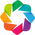

In [1]:
# Standard convention is to import python standard libraries first, then third-party libraries after that
# See list of standard libraries here: https://docs.python.org/3/library/
# Both import lists should be alphabetically sorted

# --- Python standard library --- #
import glob
import os

# --- Third-party (non-standard Python) libraries --- #
# Interactive visualizations
import holoviews as hv
hv.extension('bokeh')

# Commonly used library for plotting
import matplotlib.pyplot as plt

# Numerical python - arrays, nans
import numpy as np

# python dataframes. very similar to R dataframes
import pandas as pd

# Make the number of characters allowed per column super big since our filenames are long
pd.options.display.max_colwidth = 500

# Reminder to install pyarrow for parquet read/write
import pyarrow

# Reminder to install s3fs to read files from aws
import s3fs

# static visualizations. ggplot2-like
import seaborn as sns

# Nice status bar for 'for' loops
from tqdm import tqdm

# Show figures inside the notebook
%matplotlib inline


# Re-import libraries every time you run a cell. A lifesaver for active development!
%load_ext autoreload
%autoreload 2

In [2]:
compute_samples = pd.read_csv('lung_cancer/compute/samples.csv')
print(compute_samples.shape)
compute_samples.head()

(5054, 10)


,id,read1,read2,name,output,trim_low_abundance_kmers,dna,protein,ksizes,scaled
0,A10_B000419_S34,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B000419_S34/A10_B000419_S34_R1_001.fastq.gz,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B000419_S34/A10_B000419_S34_R2_001.fastq.gz,A10_B000419_S34,s3://olgabot-maca/lung_cancer/sourmash_v4/A10_B000419_S34.signature,True,True,True,"21,27,33,51",1000
1,A10_B000420_S82,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B000420_S82/A10_B000420_S82_R1_001.fastq.gz,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B000420_S82/A10_B000420_S82_R2_001.fastq.gz,A10_B000420_S82,s3://olgabot-maca/lung_cancer/sourmash_v4/A10_B000420_S82.signature,True,True,True,"21,27,33,51",1000
2,A10_B002073_S166,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B002073_S166/A10_B002073_S166_R1_001.fastq.gz,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B002073_S166/A10_B002073_S166_R2_001.fastq.gz,A10_B002073_S166,s3://olgabot-maca/lung_cancer/sourmash_v4/A10_B002073_S166.signature,True,True,True,"21,27,33,51",1000
3,A10_B002078_S202,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B002078_S202/A10_B002078_S202_R1_001.fastq.gz,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B002078_S202/A10_B002078_S202_R2_001.fastq.gz,A10_B002078_S202,s3://olgabot-maca/lung_cancer/sourmash_v4/A10_B002078_S202.signature,True,True,True,"21,27,33,51",1000
4,A10_B002095_S118,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B002095_S118/A10_B002095_S118_R1_001.fastq.gz,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/A10_B002095_S118/A10_B002095_S118_R2_001.fastq.gz,A10_B002095_S118,s3://olgabot-maca/lung_cancer/sourmash_v4/A10_B002095_S118.signature,True,True,True,"21,27,33,51",1000


Cannot have latest version of `awscli` ... there is a bug


    pip install awscli==1.15.83

Check the bucket that we wrote the files to:

In [3]:
! aws s3 ls s3://olgabot-maca/lung_cancer/sourmash_search/

                           PRE tabula-muris-k21-protein/
                           PRE tabula-muris-k27-protein/
                           PRE tabula-muris-k33-protein/
                           PRE tabula-muris-k51-protein/


## Use `aws s3 ls` from within Jupyter

In [4]:
! aws s3 ls s3://olgabot-maca/lung_cancer/sourmash_search/tabula-muris-k51-protein/

2018-10-05 22:27:47    6961355 C14_B003528_S62_ignore-abundance=False.csv
2018-10-05 22:20:33    7018975 C14_B003528_S62_ignore-abundance=True.csv
2018-09-23 19:39:46    6978189 D1_B003125_S25_ignore-abundance=False.csv
2018-10-05 22:00:53    7034849 D1_B003125_S25_ignore-abundance=True.csv
2018-10-05 18:51:53    6957176 E19_B003570_S199_ignore-abundance=False.csv
2018-10-05 18:54:16    7013981 E19_B003570_S199_ignore-abundance=True.csv
2018-09-23 19:01:31    6971121 F21_B000420_S213_ignore-abundance=False.csv
2018-10-05 18:28:25    7017638 F21_B000420_S213_ignore-abundance=True.csv
2018-09-23 19:40:25    6977765 G10_B003586_S142_ignore-abundance=False.csv
2018-10-05 18:23:56    7014175 G10_B003586_S142_ignore-abundance=True.csv
2018-10-05 22:34:28    6951301 G4_B003570_S232_ignore-abundance=False.csv
2018-09-23 17:10:04    7020021 G4_B003570_S232_ignore-abundance=True.csv
2018-10-05 18:51:55    6983895 G9_B003511_S57_ignore-abundance=False.csv
2018-10-05 18:39:10    7013917 G9_B003511

Now here we'll do the same thing but save the s3 location into the variable `prefix`, and save the output of the `aws s3 ls` to the text file `lung_cancer_sourmash_search.txt`, then use the command line program `cat` to con_*cat*_enate it to standard output so we can see it.

In [5]:
prefix = 's3://olgabot-maca/lung_cancer/sourmash_search/tabula-muris-k51-protein'
txt = 'lung_cancer_sourmash_search.txt'

! aws s3 ls $prefix/ > $txt
! cat $txt

2018-10-05 22:27:47    6961355 C14_B003528_S62_ignore-abundance=False.csv
2018-10-05 22:20:33    7018975 C14_B003528_S62_ignore-abundance=True.csv
2018-09-23 19:39:46    6978189 D1_B003125_S25_ignore-abundance=False.csv
2018-10-05 22:00:53    7034849 D1_B003125_S25_ignore-abundance=True.csv
2018-10-05 18:51:53    6957176 E19_B003570_S199_ignore-abundance=False.csv
2018-10-05 18:54:16    7013981 E19_B003570_S199_ignore-abundance=True.csv
2018-09-23 19:01:31    6971121 F21_B000420_S213_ignore-abundance=False.csv
2018-10-05 18:28:25    7017638 F21_B000420_S213_ignore-abundance=True.csv
2018-09-23 19:40:25    6977765 G10_B003586_S142_ignore-abundance=False.csv
2018-10-05 18:23:56    7014175 G10_B003586_S142_ignore-abundance=True.csv
2018-10-05 22:34:28    6951301 G4_B003570_S232_ignore-abundance=False.csv
2018-09-23 17:10:04    7020021 G4_B003570_S232_ignore-abundance=True.csv
2018-10-05 18:51:55    6983895 G9_B003511_S57_ignore-abundance=False.csv
2018-10-05 18:39:10    7013917 G9_B003511

## Read the table we wrote

In [6]:
aws_s3_ls = pd.read_table(txt, 
                          delim_whitespace=True, header=None, 
                          names=['date', 'time', 'bytes', 'basename'])
print(aws_s3_ls.shape)
aws_s3_ls.head()

(42, 4)


,date,time,bytes,basename
0,2018-10-05,22:27:47,6961355,C14_B003528_S62_ignore-abundance=False.csv
1,2018-10-05,22:20:33,7018975,C14_B003528_S62_ignore-abundance=True.csv
2,2018-09-23,19:39:46,6978189,D1_B003125_S25_ignore-abundance=False.csv
3,2018-10-05,22:00:53,7034849,D1_B003125_S25_ignore-abundance=True.csv
4,2018-10-05,18:51:53,6957176,E19_B003570_S199_ignore-abundance=False.csv


## Extract out the sample id and whether abundance was on or off in the search

I **always** use [regex101.com](https://regex101.com/r/UGtu79/1) to test out the regular expression and visually inspect that it's doing the right thing.

In [7]:
pattern = '(?P<sample_id>[\w]+)_ignore-abundance=(?P<ignore_abundance>True|False).csv'

sample_id_abundance = aws_s3_ls.basename.str.extract(pattern)
print(sample_id_abundance.shape)
sample_id_abundance.head()

(42, 2)


,sample_id,ignore_abundance
0,C14_B003528_S62,False
1,C14_B003528_S62,True
2,D1_B003125_S25,False
3,D1_B003125_S25,True
4,E19_B003570_S199,False


Look at all sample ids, sorted. There should be two each - one with and without abundance.

In [8]:
sorted(sample_id_abundance.sample_id.values)

['C14_B003528_S62',
 'C14_B003528_S62',
 'D1_B003125_S25',
 'D1_B003125_S25',
 'E19_B003570_S199',
 'E19_B003570_S199',
 'F21_B000420_S213',
 'F21_B000420_S213',
 'G10_B003586_S142',
 'G10_B003586_S142',
 'G4_B003570_S232',
 'G4_B003570_S232',
 'G9_B003511_S57',
 'G9_B003511_S57',
 'H7_B003588_S211',
 'H7_B003588_S211',
 'I22_B002095_S22',
 'I22_B002095_S22',
 'I3_B003573_S63',
 'I3_B003573_S63',
 'J11_B003573_S95',
 'J11_B003573_S95',
 'J8_B003528_S224',
 'J8_B003528_S224',
 'K7_B002073_S103',
 'K7_B002073_S103',
 'L16_B003588_S16',
 'L16_B003588_S16',
 'L5_B003588_S5',
 'L5_B003588_S5',
 'M1_B000420_S61',
 'M1_B000420_S61',
 'M23_B002097_S251',
 'M23_B002097_S251',
 'N15_B000420_S99',
 'N15_B000420_S99',
 'O3_B003573_S207',
 'O3_B003573_S207',
 'P14_B000420_S146',
 'P14_B000420_S146',
 'P2_B003125_S14',
 'P2_B003125_S14']

### Combine the sample ids + abundance info and the `aws s3 ls` results

Here, we're adding the `sample_id_abundace` to the right, like "cbind" you may have seen in other languages.

In [9]:
aws_s3_ls_ids = pd.concat([aws_s3_ls, sample_id_abundance], axis=1)
print(aws_s3_ls_ids.shape)
aws_s3_ls_ids.head()

(42, 6)


,date,time,bytes,basename,sample_id,ignore_abundance
0,2018-10-05,22:27:47,6961355,C14_B003528_S62_ignore-abundance=False.csv,C14_B003528_S62,False
1,2018-10-05,22:20:33,7018975,C14_B003528_S62_ignore-abundance=True.csv,C14_B003528_S62,True
2,2018-09-23,19:39:46,6978189,D1_B003125_S25_ignore-abundance=False.csv,D1_B003125_S25,False
3,2018-10-05,22:00:53,7034849,D1_B003125_S25_ignore-abundance=True.csv,D1_B003125_S25,True
4,2018-10-05,18:51:53,6957176,E19_B003570_S199_ignore-abundance=False.csv,E19_B003570_S199,False


### Read one of the files *DIRECTLY FROM S3* liek omg omg omg

Here we're demonstrating that we can read csvs (really any text files) **directly** from S3!

In [10]:
pd.read_csv('s3://olgabot-maca/lung_cancer/sourmash_search/tabula-muris-k51-protein/D1_B003125_S25_ignore-abundance=False.csv')

,similarity,name,filename,md5
0,0.316674,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:G16-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,7eaedc3ea86056aca4353152544cfff4
1,0.308141,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:E11-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,9c2251f947b9a9faf1cad898f2b1a0a1
2,0.307184,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:D12-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,942b9c25aed5b57d64572cdcbd8d3343
3,0.304018,cell_ontology_class:endothelial_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:D17-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,5e9de85eef4edef22566bb3eb1efc23b
4,0.302058,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:H14-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,2e4adc68cd4fd8e1c6119571c859ca71
5,0.295595,cell_ontology_class:mesenchymal_stem_cell_of_adipose|tissue:Fat|subtissue:MAT|free_annotation:mesenchymal_progenitor|cell_id:F22-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,50bc794f6bece240f527701092b9cea7
6,0.295274,cell_ontology_class:B_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:H11-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,4a57f585286a96123dec203d75814298
7,0.294603,B17-MAA000574-3_8_M-1-1,tabula-muris-k51-protein,d9396f2d3cab5dbe8248709402723f1a
8,0.292394,cell_ontology_class:B_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:E13-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,f21d112b9901e8d83ab492e626e856a4
9,0.291830,cell_ontology_class:B_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:G8-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,2c54fcffdbdbcccee3da153ac2e41cbb


Now we're doing the same thing, but using variables because we're good coders.

In [11]:
csv = f'{prefix}/D1_B003125_S25_ignore-abundance=False.csv'
print("reading:", csv)
df = pd.read_csv(csv)
print(df.shape)
df.head()

reading: s3://olgabot-maca/lung_cancer/sourmash_search/tabula-muris-k51-protein/D1_B003125_S25_ignore-abundance=False.csv
(36616, 4)


,similarity,name,filename,md5
0,0.316674,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:G16-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,7eaedc3ea86056aca4353152544cfff4
1,0.308141,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:E11-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,9c2251f947b9a9faf1cad898f2b1a0a1
2,0.307184,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:D12-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,942b9c25aed5b57d64572cdcbd8d3343
3,0.304018,cell_ontology_class:endothelial_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:D17-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,5e9de85eef4edef22566bb3eb1efc23b
4,0.302058,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:H14-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,2e4adc68cd4fd8e1c6119571c859ca71


Notice that we show the number of rows and columns of the dataframe with `print(df.shape)` and the first 5 rows with `df.head()`. You should do this EVERY single time you transform your dataframe, to make sure what you thought would happen actually happened. I've totally screwed myself over by not double checking at every step so make sure you save yourself!

## Read all the csvs and use `tqdm` to show how fast we're going

[`tqdm`](https://github.com/tqdm/tqdm), meaning "progress" in Arabic, is a super useful tool that shows you how quickly your loop is going. From before, we can see that the size of the `aws_s3_ls` dataframe is 42 and we can watch as the iteration proceeds.  

We'll also use the `%%time` magic to see how long it all takes. You can read more about the built-in Jupyter magics [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html). The key thing to note is that a single percent sign `%` indicates a magic that only operates on that line, e.g. the

    %time df = pd.read_csv(csv)

line, while `%%time` with two percent signs `%` will capture the time of the whole cell. Note that the double percent sign ones must be the FIRST line in the cell.

In [12]:
%%time

dfs = []

for i, row in tqdm(aws_s3_ls_ids.iterrows()):
    basename = row.basename
    sample_id = basename.split()
    csv = f'{prefix}/{basename}' 
    %time df = pd.read_csv(csv)
    df['query_sample_id'] = row.sample_id
    df['ignore_abundance'] = row.ignore_abundance
    dfs.append(df)
search_results = pd.concat(dfs, ignore_index=True)
print(search_results.shape)
search_results.head()

1it [00:00,  1.36it/s]

CPU times: user 146 ms, sys: 36.1 ms, total: 182 ms
Wall time: 732 ms


2it [00:01,  1.35it/s]

CPU times: user 142 ms, sys: 28.9 ms, total: 171 ms
Wall time: 752 ms


3it [00:02,  1.44it/s]

CPU times: user 145 ms, sys: 36.2 ms, total: 181 ms
Wall time: 586 ms


4it [00:02,  1.42it/s]

CPU times: user 148 ms, sys: 38.9 ms, total: 187 ms
Wall time: 719 ms


5it [00:03,  1.45it/s]

CPU times: user 144 ms, sys: 30.2 ms, total: 174 ms
Wall time: 656 ms


6it [00:04,  1.40it/s]

CPU times: user 146 ms, sys: 38.5 ms, total: 185 ms
Wall time: 760 ms


7it [00:04,  1.42it/s]

CPU times: user 143 ms, sys: 31.2 ms, total: 175 ms
Wall time: 687 ms


8it [00:05,  1.37it/s]

CPU times: user 142 ms, sys: 30.8 ms, total: 173 ms
Wall time: 785 ms


9it [00:06,  1.33it/s]

CPU times: user 151 ms, sys: 38.3 ms, total: 189 ms
Wall time: 796 ms


10it [00:07,  1.29it/s]

CPU times: user 141 ms, sys: 30.9 ms, total: 172 ms
Wall time: 819 ms


11it [00:08,  1.30it/s]

CPU times: user 145 ms, sys: 27.4 ms, total: 173 ms
Wall time: 747 ms


12it [00:08,  1.32it/s]

CPU times: user 147 ms, sys: 38 ms, total: 185 ms
Wall time: 734 ms


13it [00:09,  1.30it/s]

CPU times: user 155 ms, sys: 34.6 ms, total: 190 ms
Wall time: 801 ms


14it [00:10,  1.31it/s]

CPU times: user 146 ms, sys: 31.2 ms, total: 177 ms
Wall time: 737 ms


15it [00:11,  1.30it/s]

CPU times: user 147 ms, sys: 35 ms, total: 182 ms
Wall time: 776 ms


16it [00:11,  1.33it/s]

CPU times: user 147 ms, sys: 34.4 ms, total: 181 ms
Wall time: 713 ms


17it [00:12,  1.32it/s]

CPU times: user 142 ms, sys: 30.4 ms, total: 173 ms
Wall time: 764 ms


18it [00:13,  1.35it/s]

CPU times: user 151 ms, sys: 37.9 ms, total: 188 ms
Wall time: 701 ms


19it [00:14,  1.39it/s]

CPU times: user 147 ms, sys: 34.7 ms, total: 181 ms
Wall time: 662 ms


20it [00:14,  1.42it/s]

CPU times: user 143 ms, sys: 29.3 ms, total: 173 ms
Wall time: 665 ms


21it [00:15,  1.45it/s]

CPU times: user 147 ms, sys: 36.2 ms, total: 184 ms
Wall time: 654 ms


22it [00:15,  1.47it/s]

CPU times: user 150 ms, sys: 35 ms, total: 185 ms
Wall time: 660 ms


23it [00:16,  1.46it/s]

CPU times: user 143 ms, sys: 29.3 ms, total: 172 ms
Wall time: 681 ms


24it [00:17,  1.49it/s]

CPU times: user 145 ms, sys: 39 ms, total: 184 ms
Wall time: 634 ms


25it [00:17,  1.50it/s]

CPU times: user 146 ms, sys: 35.1 ms, total: 181 ms
Wall time: 649 ms


26it [00:18,  1.51it/s]

CPU times: user 141 ms, sys: 29.8 ms, total: 170 ms
Wall time: 648 ms


27it [00:19,  1.51it/s]

CPU times: user 137 ms, sys: 25.3 ms, total: 162 ms
Wall time: 661 ms


28it [00:19,  1.53it/s]

CPU times: user 157 ms, sys: 42 ms, total: 199 ms
Wall time: 631 ms


29it [00:20,  1.54it/s]

CPU times: user 144 ms, sys: 34.2 ms, total: 179 ms
Wall time: 628 ms


30it [00:21,  1.53it/s]

CPU times: user 144 ms, sys: 30.4 ms, total: 174 ms
Wall time: 670 ms


31it [00:21,  1.52it/s]

CPU times: user 144 ms, sys: 37.2 ms, total: 182 ms
Wall time: 656 ms


32it [00:23,  1.23it/s]

CPU times: user 153 ms, sys: 34.8 ms, total: 188 ms
Wall time: 1.18 s


33it [00:23,  1.33it/s]

CPU times: user 132 ms, sys: 28.7 ms, total: 161 ms
Wall time: 606 ms


34it [00:24,  1.37it/s]

CPU times: user 145 ms, sys: 38.2 ms, total: 184 ms
Wall time: 671 ms


35it [00:25,  1.37it/s]

CPU times: user 152 ms, sys: 36.6 ms, total: 189 ms
Wall time: 720 ms


36it [00:25,  1.41it/s]

CPU times: user 148 ms, sys: 31.3 ms, total: 179 ms
Wall time: 669 ms


37it [00:26,  1.19it/s]

CPU times: user 156 ms, sys: 40.2 ms, total: 196 ms
Wall time: 1.13 s


38it [00:27,  1.16it/s]

CPU times: user 148 ms, sys: 32.1 ms, total: 180 ms
Wall time: 912 ms


39it [00:28,  1.20it/s]

CPU times: user 156 ms, sys: 39.6 ms, total: 196 ms
Wall time: 771 ms


40it [00:29,  1.18it/s]

CPU times: user 174 ms, sys: 37.9 ms, total: 211 ms
Wall time: 866 ms


41it [00:30,  1.19it/s]

CPU times: user 165 ms, sys: 38.5 ms, total: 203 ms
Wall time: 826 ms


42it [00:31,  1.04it/s]

CPU times: user 183 ms, sys: 44.1 ms, total: 227 ms
Wall time: 1.22 s


(1537872, 6)
CPU times: user 7.18 s, sys: 1.54 s, total: 8.72 s
Wall time: 32.4 s


In other cases, you get a nice-looking progress bar, but `aws_s3_ls_ids.iterrows()` returns an iterator, not a list so no-one knows the total size *a priori*.

In the example below, you get the nice-looking bar.

In [13]:
for i in tqdm(range(500)):
    # If i is divisible by 100 with 0 remainder
    if i % 100 == 0:
        print(i)

100%|██████████| 500/500 [00:00<00:00, 301141.87it/s]

0
100
200
300
400


## Write `extract_metadata.py` file with utility functions that we'll use across notebooks

Now we're going to write a bunch of functions. But because these functions are SO USEFUL we're probably going to need them in different Jupyter Notebooks. So we'll write a file called `extract_metadata.py` using the `%%file` magic, and then we can import it like we import any other package, with `import extract_metadata`.

This is really useful because then you only need to change the code in one place! Rather than having to copy/paste the new function into each file, which is just calling for disaster

In [14]:
%%file extract_metadata.py
import numpy as np
import pandas as pd

def combine_cell_ontology_free_annotation(row):
    if pd.notnull(row['free_annotation']):
        return '{cell_ontology_class} ({free_annotation})'.format(**row)
    else:
        return row['cell_ontology_class']


def extract_cell_metadata(name_column, pattern='(?P<column>\w+):(?P<value>[\w-]+)'):
    expanded = name_column.str.extractall(pattern)
    expanded_index = expanded.reset_index()
    annotations = expanded_index.pivot(columns='column', values='value', index='level_0')
    
    # Convert "nan" strings to actual NaN objects
    annotations[annotations == "nan"] = np.nan
    annotations['cell_ontology_free_annotation'] = annotations.apply(
        combine_cell_ontology_free_annotation, axis=1)
    return annotations 


def to_key_value_pair(attribute):
    if len(attribute) > 1:
        try:
            return attribute[0], int(attribute[1])
        except ValueError:
            return attribute[0], attribute[1] 
    else:
        return 'comparison_sequence', attribute[0]


def extract_experiment_metadata(basename):
    key = basename.split('.csv')[0]
    split = key.split('_')
    attributes = [x.split('=') for x in split]
    attributes = dict(to_key_value_pair(x) for x in attributes)
    return key, attributes

Overwriting extract_metadata.py


### Import the file we just wrote and use the `extract_cell_metadata` function

Now we'll import our `extract_metadata.py` file with `import extract_metadata`!

In [15]:
import extract_metadata

cell_metadata = extract_metadata.extract_cell_metadata(search_results.name)
print(cell_metadata.shape)
cell_metadata.head()

(1239630, 6)


column,cell_id,cell_ontology_class,free_annotation,subtissue,tissue,cell_ontology_free_annotation
level_0,,,,,,
0,H11-B002314-3_56_F-1-1,myeloid_cell,NaN,MAT,Fat,myeloid_cell
1,H6-MAA001871-3_39_F-1-1,epithelial_cell_of_large_intestine,Lgr5-_amplifying_undifferentiated_cell,Proximal,Large_Intestine,epithelial_cell_of_large_intestine (Lgr5-_amplifying_undifferentiated_cell)
2,M4-MAA001872-3_39_F-1-1,large_intestine_goblet_cell,Goblet_cell_,Proximal,Large_Intestine,large_intestine_goblet_cell (Goblet_cell_)
3,E6-MAA001872-3_39_F-1-1,large_intestine_goblet_cell,Goblet_cell_,Proximal,Large_Intestine,large_intestine_goblet_cell (Goblet_cell_)
4,L12-MAA001872-3_39_F-1-1,large_intestine_goblet_cell,Goblet_cell_,Proximal,Large_Intestine,large_intestine_goblet_cell (Goblet_cell_)


## `join` the search results on the metadata

Notice that the `index` (the `pandas` word for row names) of both are the same - they are the same size and have the same number of rows

In [16]:
search_results_metadata = search_results.join(cell_metadata)
print(search_results_metadata.shape)
search_results_metadata.head()

(1537872, 12)


,similarity,name,filename,md5,query_sample_id,ignore_abundance,cell_id,cell_ontology_class,free_annotation,subtissue,tissue,cell_ontology_free_annotation
0,0.500983,cell_ontology_class:myeloid_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:H11-B002314-3_56_F-1-1,tabula-muris-k51-protein,3117952b86d451cb92e6336531316c17,C14_B003528_S62,False,H11-B002314-3_56_F-1-1,myeloid_cell,NaN,MAT,Fat,myeloid_cell
1,0.500967,cell_ontology_class:epithelial_cell_of_large_intestine|tissue:Large_Intestine|subtissue:Proximal|free_annotation:Lgr5-_amplifying_undifferentiated_cell|cell_id:H6-MAA001871-3_39_F-1-1,tabula-muris-k51-protein,3c5b05b218dc4bfdc197426bc838fed8,C14_B003528_S62,False,H6-MAA001871-3_39_F-1-1,epithelial_cell_of_large_intestine,Lgr5-_amplifying_undifferentiated_cell,Proximal,Large_Intestine,epithelial_cell_of_large_intestine (Lgr5-_amplifying_undifferentiated_cell)
2,0.500855,cell_ontology_class:large_intestine_goblet_cell|tissue:Large_Intestine|subtissue:Proximal|free_annotation:Goblet_cell_(Proximal)|cell_id:M4-MAA001872-3_39_F-1-1,tabula-muris-k51-protein,64ef4f62c0d0b1377c2cbf5f135f314f,C14_B003528_S62,False,M4-MAA001872-3_39_F-1-1,large_intestine_goblet_cell,Goblet_cell_,Proximal,Large_Intestine,large_intestine_goblet_cell (Goblet_cell_)
3,0.500827,cell_ontology_class:large_intestine_goblet_cell|tissue:Large_Intestine|subtissue:Proximal|free_annotation:Goblet_cell_(Proximal)|cell_id:E6-MAA001872-3_39_F-1-1,tabula-muris-k51-protein,e4a3ceeaeff81c54fe23210e460e6ded,C14_B003528_S62,False,E6-MAA001872-3_39_F-1-1,large_intestine_goblet_cell,Goblet_cell_,Proximal,Large_Intestine,large_intestine_goblet_cell (Goblet_cell_)
4,0.500819,cell_ontology_class:large_intestine_goblet_cell|tissue:Large_Intestine|subtissue:Proximal|free_annotation:Goblet_cell_(Proximal)|cell_id:L12-MAA001872-3_39_F-1-1,tabula-muris-k51-protein,a8a5aa310cbb862741fc88fac1052c32,C14_B003528_S62,False,L12-MAA001872-3_39_F-1-1,large_intestine_goblet_cell,Goblet_cell_,Proximal,Large_Intestine,large_intestine_goblet_cell (Goblet_cell_)


## Before we do anything else... SAVE!

We've read in all these files and transformed them a bit. Let's not lose our work!! So we'll write our 

Write the files directly to AWS. This is not as straightforward as just using a filename that starts with `s3://` so I wrote this utility function that we can use across notebooks.

In [17]:
%%file s3_utils.py
import s3fs

def write_s3(df, filename, fmt='csv', **kwargs):
    fs = s3fs.S3FileSystem(anon=False)
    if fmt == 'csv':
        # csv is a text format
        with fs.open(filename, 'w') as f:
            return df.to_csv(f, **kwargs)
    elif fmt == 'parquet':
        # Parquet is a binary format and needs the "b" flag
        with fs.open(filename, 'wb') as f:
            return df.to_parquet(f, **kwargs)


Overwriting s3_utils.py


### What is "parquet"?

[Parquet](https://parquet.apache.org/) is an efficient file format that is very good for **columnar** data storage, think metadata in [tidy data](http://vita.had.co.nz/papers/tidy-data.html) style. 

It's NOT good for storing big, sparse count matrices like gene expression data - use [hdf5](http://docs.h5py.org/en/stable/) for that. Pandas can directly [read/write hdf5](https://pandas.pydata.org/pandas-docs/stable/io.html#hdf5) and [xarray](http://xarray.pydata.org/en/stable/) is a great library for working with tons of labeled, indexed sparse matrices.

Let's take a look at how quickly the search results file gets written in csv vs parquet format, using the `%time` magic to capture the time it takes for a single line.

In [18]:
import s3_utils

fmt = 'csv'

%time s3_utils.write_s3(search_results_metadata, f's3://olgabot-maca/facs/lung_cancer_v4_metadata.{fmt}', fmt=fmt)

CPU times: user 19 s, sys: 2.75 s, total: 21.8 s
Wall time: 1min 16s


In [19]:
fmt = 'parquet'

%time s3_utils.write_s3(search_results_metadata, f's3://olgabot-maca/facs/lung_cancer_v4_metadata.{fmt}', fmt=fmt)

CPU times: user 4.78 s, sys: 1.29 s, total: 6.07 s
Wall time: 59.7 s


## Do some plotting!!! 

Finally, let's make some pictures!

Let's take a look at the overall distribution of the similarity scores using a [`kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) aka a smoothed histogram.

/anaconda3/envs/bioinformagician/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


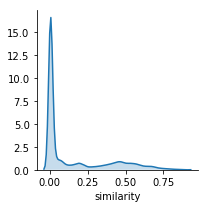

In [20]:
g = sns.FacetGrid(search_results_metadata)
g.map(sns.kdeplot, 'similarity', shade=True)

### Is similarity different for different target Tabula Muris tissues?

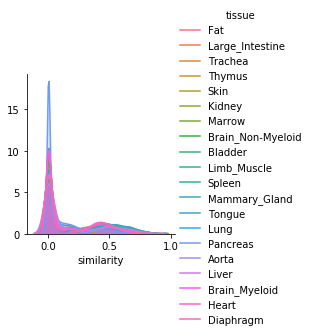

In [21]:
g = sns.FacetGrid(search_results_metadata, hue='tissue')
g.map(sns.kdeplot, 'similarity', shade=True)
g.add_legend()

### Is similarity different when `ignore_abundance` is True or False?

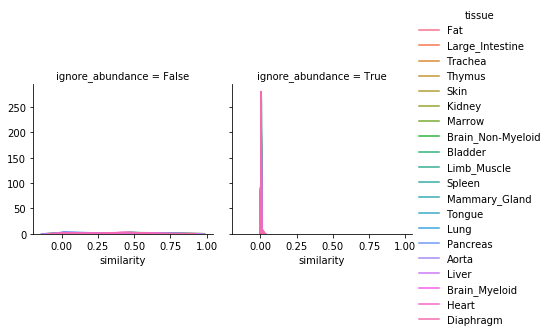

In [22]:
g = sns.FacetGrid(search_results_metadata, col='ignore_abundance', hue='tissue')
g.map(sns.kdeplot, 'similarity', shade=True)
g.add_legend()

#### Same plot, but made interactive with [`holoviews`](http://holoviews.org)

In [23]:
%%opts Distribution [filled=False, tools=['hover'] width=800 height=600] 
%%opts Distribution (line_color=Cycle("Category20"))
%%opts NdOverlay [legend_position='left']


hmap = hv.HoloMap({ignore_abundance: hv.NdOverlay({name: hv.Distribution(df['similarity']) 
              for name, df in abundance_df.groupby('tissue')})
                   for ignore_abundance, abundance_df 
                   in search_results_metadata.groupby('ignore_abundance')}, 
                  kdims=['ignore_abundance'])
hmap.layout('ignore_abundance')

:NdLayout   [ignore_abundance]
   :NdOverlay   [Element]
      :Distribution   [similarity]   (Density)

### What about by cell ontology class?

/anaconda3/envs/bioinformagician/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


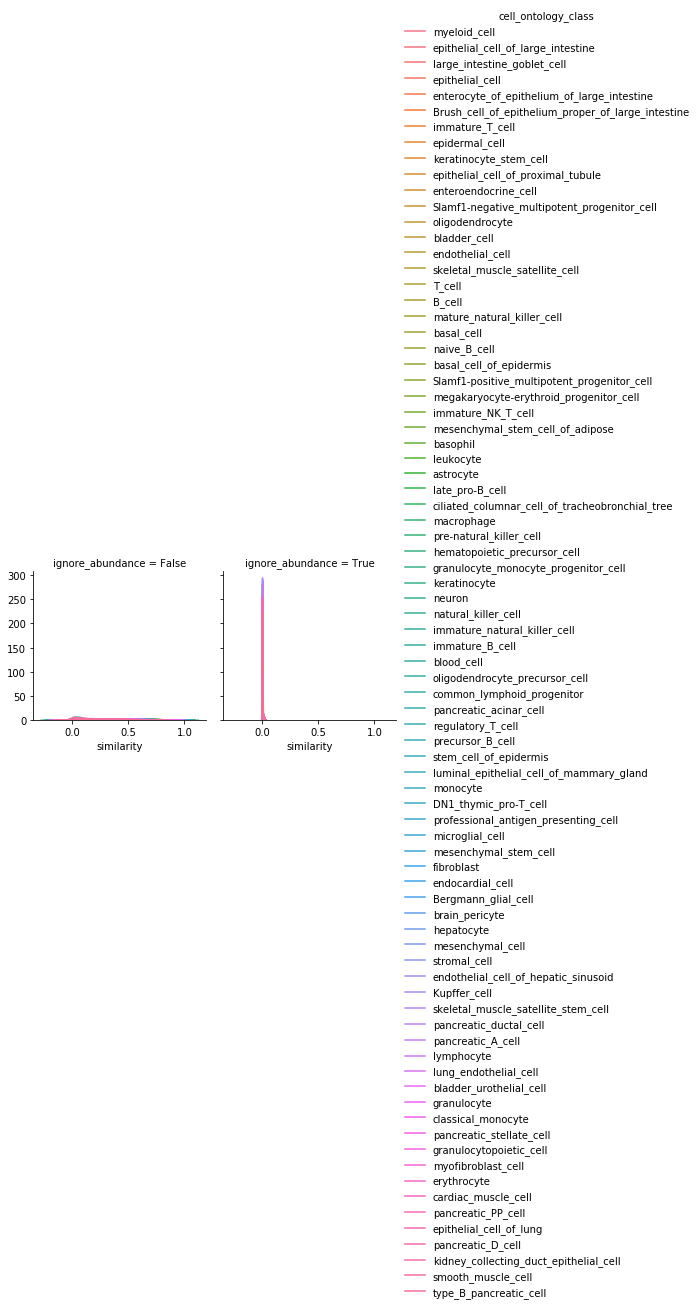

In [24]:

g = sns.FacetGrid(search_results_metadata, col='ignore_abundance', hue='cell_ontology_class')
g.map(sns.kdeplot, 'similarity', shade=True)
g.add_legend()


## Get the most commonly similar cell ontology class for the best 100 matches

Best = highest similarity, so if we sort by the largest similarity score, we'll have the best!

Use `mode` (remember mean, median and mode?) since we want the celltype that appears the most often in the closest 100 cells.

In [42]:
grouped = search_results_metadata.groupby(['query_sample_id', 'ignore_abundance'])

cell_ontology_class_guess = grouped.apply( 
    # Need to force `astype(str)` otherwise get an error 
    # of comparing floats (NaNs) to strings
    lambda x: x.nlargest(100, 'similarity')['cell_ontology_class'].mode())
cell_ontology_class_guess

query_sample_id   ignore_abundance   
C14_B003528_S62   False             0             epithelial_cell_of_large_intestine
                  True              0             epithelial_cell_of_large_intestine
D1_B003125_S25    False             0               mesenchymal_stem_cell_of_adipose
                  True              0                         pancreatic_acinar_cell
E19_B003570_S199  False             0             epithelial_cell_of_large_intestine
                  True              0                                     basal_cell
F21_B000420_S213  False             0                                         B_cell
                  True              0             epithelial_cell_of_large_intestine
G4_B003570_S232   False             0             epithelial_cell_of_large_intestine
                  True              0             epithelial_cell_of_large_intestine
G9_B003511_S57    True              0                                oligodendrocyte
H7_B003588_S211   False    

### What about the most common tissues?

In [43]:
grouped.apply(lambda x: x.nlargest(100, 'similarity')['tissue'].mode())

query_sample_id   ignore_abundance   
C14_B003528_S62   False             0      Large_Intestine
                  True              0      Large_Intestine
D1_B003125_S25    False             0                  Fat
                  True              0             Pancreas
E19_B003570_S199  False             0      Large_Intestine
                  True              0        Mammary_Gland
F21_B000420_S213  False             0               Spleen
                  True              0                  Fat
G4_B003570_S232   False             0      Large_Intestine
                  True              0      Large_Intestine
G9_B003511_S57    True              0    Brain_Non-Myeloid
H7_B003588_S211   False             0      Large_Intestine
                  True              0      Large_Intestine
I22_B002095_S22   False             0      Large_Intestine
                  True              0               Marrow
I3_B003573_S63    False             0                Heart
                  

### Make a dataframe of the cell ontology class guesses

In [27]:
cell_ontology_class_guess_df = cell_ontology_class_guess.reset_index()
cell_ontology_class_guess_df

,query_sample_id,ignore_abundance,level_2,0
0,C14_B003528_S62,False,0,epithelial_cell_of_large_intestine
1,C14_B003528_S62,True,0,epithelial_cell_of_large_intestine
2,D1_B003125_S25,False,0,mesenchymal_stem_cell_of_adipose
3,D1_B003125_S25,True,0,pancreatic_acinar_cell
4,E19_B003570_S199,False,0,epithelial_cell_of_large_intestine
5,E19_B003570_S199,True,0,basal_cell
6,F21_B000420_S213,False,0,B_cell
7,F21_B000420_S213,True,0,epithelial_cell_of_large_intestine
8,G4_B003570_S232,False,0,epithelial_cell_of_large_intestine
9,G4_B003570_S232,True,0,epithelial_cell_of_large_intestine


### Pivot the dataframe so that "ignore_abundance=True,False" are the columns and the sampel ids are the rows

In [28]:
cell_ontology_class_guess_pivotted = cell_ontology_class_guess_df.pivot(
    index='query_sample_id', columns='ignore_abundance', values=0)

# Set everything as a string for now
cell_ontology_class_guess_pivotted = cell_ontology_class_guess_pivotted.astype(str)
cell_ontology_class_guess_pivotted

ignore_abundance,False,True
query_sample_id,,
C14_B003528_S62,epithelial_cell_of_large_intestine,epithelial_cell_of_large_intestine
D1_B003125_S25,mesenchymal_stem_cell_of_adipose,pancreatic_acinar_cell
E19_B003570_S199,epithelial_cell_of_large_intestine,basal_cell
F21_B000420_S213,B_cell,epithelial_cell_of_large_intestine
G4_B003570_S232,epithelial_cell_of_large_intestine,epithelial_cell_of_large_intestine
G9_B003511_S57,nan,oligodendrocyte
H7_B003588_S211,epithelial_cell_of_large_intestine,epithelial_cell_of_large_intestine
I22_B002095_S22,epithelial_cell_of_large_intestine,Slamf1-negative_multipotent_progenitor_cell
I3_B003573_S63,leukocyte,myeloid_cell


In [29]:
sorted_cell_ontology_classes = sorted(np.unique(cell_ontology_class_guess_pivotted.astype(str).values.flat))
sorted_cell_ontology_classes

['B_cell',
 'Slamf1-negative_multipotent_progenitor_cell',
 'basal_cell',
 'endothelial_cell',
 'epithelial_cell_of_large_intestine',
 'leukocyte',
 'mesenchymal_stem_cell_of_adipose',
 'myeloid_cell',
 'nan',
 'oligodendrocyte',
 'pancreatic_acinar_cell']

In [30]:
from sklearn.metrics import confusion_matrix


matrix = confusion_matrix(cell_ontology_class_guess_pivotted['True'], 
                          cell_ontology_class_guess_pivotted['False'],
                         labels=sorted_cell_ontology_classes)
matrix

array([[ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0]])

Make a dataframe because they are better

In [31]:
confusion_df = pd.DataFrame(matrix, index=sorted_cell_ontology_classes, columns=sorted_cell_ontology_classes)
confusion_df

,B_cell,Slamf1-negative_multipotent_progenitor_cell,basal_cell,endothelial_cell,epithelial_cell_of_large_intestine,leukocyte,mesenchymal_stem_cell_of_adipose,myeloid_cell,nan,oligodendrocyte,pancreatic_acinar_cell
B_cell,0,0,0,0,1,0,0,0,0,0,0
Slamf1-negative_multipotent_progenitor_cell,0,0,0,0,1,0,0,0,0,0,0
basal_cell,0,0,0,0,1,0,0,0,0,0,0
endothelial_cell,0,0,0,1,0,0,0,0,0,0,0
epithelial_cell_of_large_intestine,1,0,0,0,12,0,0,0,0,0,0
leukocyte,0,0,0,0,0,0,0,0,0,0,0
mesenchymal_stem_cell_of_adipose,0,0,0,0,0,0,0,0,0,0,0
myeloid_cell,0,0,0,0,0,1,0,0,0,0,0
nan,0,0,0,0,0,0,0,0,0,0,0
oligodendrocyte,0,0,0,0,0,0,0,0,1,0,0


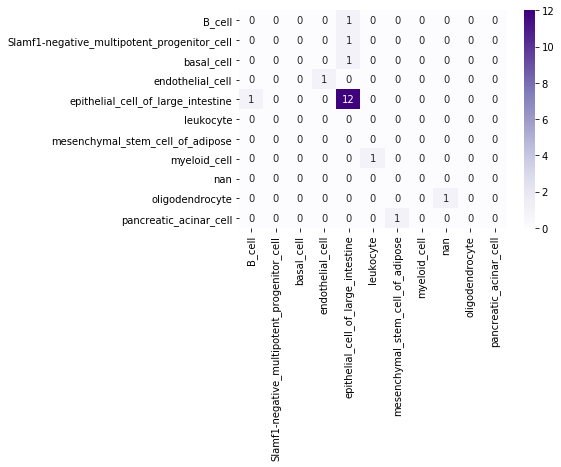

In [32]:
sns.heatmap(confusion_df, annot=True, cmap='Purples')

### Now let's make some interactive plots!

In [33]:
%%opts Distribution [filled=False, tools=['hover'] width=800 height=600] 
%%opts Distribution (line_color=Cycle("Category20"))
%%opts NdOverlay [legend_position='right']


hv.NdOverlay({name: hv.Distribution(df['similarity']) 
              for name, df in search_results_metadata.groupby('tissue')})

:NdOverlay   [Element]
   :Distribution   [similarity]   (Density)

Help message from holoviews

In [34]:
# hv.help(hv.NdOverlay)

In [35]:
%%opts Distribution [filled=False, tools=['hover'] width=800 height=600] 
%%opts Distribution (line_color=Cycle("Category20"))
%%opts NdOverlay [legend_position='left']


hmap = hv.HoloMap({ignore_abundance: hv.NdOverlay({name: hv.Distribution(df['similarity']) 
              for name, df in abundance_df.groupby('tissue')})
                   for ignore_abundance, abundance_df 
                   in search_results_metadata.groupby('ignore_abundance')}, 
                  kdims=['ignore_abundance'])
hmap.layout('ignore_abundance')

:NdLayout   [ignore_abundance]
   :NdOverlay   [Element]
      :Distribution   [similarity]   (Density)

In [36]:
%%opts Distribution [filled=False, tools=['hover'] width=800 height=600] 
%%opts Distribution (line_color=Cycle())
%%opts NdOverlay [legend_position='right']

groupby = 'cell_ontology_class'

hv.NdOverlay({name: hv.Distribution(df['similarity']) 
              for name, df in search_results_metadata.groupby(groupby)})

:NdOverlay   [Element]
   :Distribution   [similarity]   (Density)

## Exercise: make faceted plot where the facets are the "ignore abundance" column and the colors are the cell ontology classes

In [ ]:
# your code goes here

## Look at median similarity per cell ontology per cell

In [97]:
median_cell_ontology = search_results_metadata.groupby(
    ['query_sample_id', "cell_ontology_class", "ignore_abundance"])['similarity'].median()
median_cell_ontology = median_cell_ontology.unstack(level=0)
# median_cell_ontology = median_cell_ontology.reset_index()

# Set the ignore_abundance level as the outer level for easier subsetting
median_cell_ontology = median_cell_ontology.swaplevel()

# Sort the index
median_cell_ontology = median_cell_ontology.sort_index()

# median_cell_ontology = median_cell_ontology.T
print(median_cell_ontology.shape)
median_cell_ontology.head()

(162, 21)


query_sample_id                                                      C14_B003528_S62  \
ignore_abundance cell_ontology_class                                                   
False            B_cell                                                     0.408400   
                 Bergmann_glial_cell                                        0.354239   
                 Brush_cell_of_epithelium_proper_of_large_intestine         0.484145   
                 DN1_thymic_pro-T_cell                                      0.457115   
                 Kupffer_cell                                               0.420838   

query_sample_id                                                      D1_B003125_S25  \
ignore_abundance cell_ontology_class                                                  
False            B_cell                                                    0.082705   
                 Bergmann_glial_cell                                       0.070570   
                 Brush_cell_of_epithelium_proper_of_large_intestine        0.080313   
                 DN1_thymic_pro-T_cell                                     0.072987   
                 Kupffer_cell                                              0.078344   

query_sample_id                                                      E19_B003570_S199  \
ignore_abundance cell_ontology_class                                                    
False            B_cell                                                      0.443318   
                 Bergmann_glial_cell                                         0.382745   
                 Brush_cell_of_epithelium_proper_of_large_intestine          0.525380   
                 DN1_thymic_pro-T_cell                                       0.498866   
                 Kupffer_cell                                                0.461157   

query_sample_id                                                      F21_B000420_S213  \
ignore_abundance cell_ontology_class                                                    
False            B_cell                                                      0.175947   
                 Bergmann_glial_cell                                         0.154124   
                 Brush_cell_of_epithelium_proper_of_large_intestine          0.199623   
                 DN1_thymic_pro-T_cell                                       0.188804   
                 Kupffer_cell                                                0.178697   

query_sample_id                                                      G10_B003586_S142  \
ignore_abundance cell_ontology_class                                                    
False            B_cell                                                      0.086342   
                 Bergmann_glial_cell                                         0.045744   
                 Brush_cell_of_epithelium_proper_of_large_intestine          0.017568   
                 DN1_thymic_pro-T_cell                                       0.047439   
                 Kupffer_cell                                                0.041790   

query_sample_id                                                      G4_B003570_S232  \
ignore_abundance cell_ontology_class                                                   
False            B_cell                                                     0.583363   
                 Bergmann_glial_cell                                        0.498738   
                 Brush_cell_of_epithelium_proper_of_large_intestine         0.759176   
                 DN1_thymic_pro-T_cell                                      0.675051   
                 Kupffer_cell                                               0.608241   

query_sample_id                                                      G9_B003511_S57  \
ignore_abundance cell_ontology_class                                                  
False            B_cell                                                    0.058065   
                 Bergma

Ignore abundance "True" and "False" are strings so can subset this way:

In [102]:
median_cell_ontology_yes_abundance = median_cell_ontology.loc["False", :]
median_cell_ontology_yes_abundance.head()

query_sample_id,C14_B003528_S62,D1_B003125_S25,E19_B003570_S199,F21_B000420_S213,G10_B003586_S142,G4_B003570_S232,G9_B003511_S57,H7_B003588_S211,I22_B002095_S22,I3_B003573_S63,...,J8_B003528_S224,K7_B002073_S103,L16_B003588_S16,L5_B003588_S5,M1_B000420_S61,M23_B002097_S251,N15_B000420_S99,O3_B003573_S207,P14_B000420_S146,P2_B003125_S14
cell_ontology_class,,,,,,,,,,,,,,,,,,,,,
B_cell,0.408400,0.082705,0.443318,0.175947,0.086342,0.583363,0.058065,0.606427,0.476116,0.444001,...,0.545013,0.467907,0.536913,0.608273,0.492330,0.0,0.566663,0.489738,0.537847,0.198416
Bergmann_glial_cell,0.354239,0.070570,0.382745,0.154124,0.045744,0.498738,0.033321,0.517108,0.410480,0.414135,...,0.469662,0.400728,0.462825,0.517400,0.423162,0.0,0.485759,0.424743,0.461764,0.173956
Brush_cell_of_epithelium_proper_of_large_intestine,0.484145,0.080313,0.525380,0.199623,0.017568,0.759176,0.012982,0.811287,0.569243,0.461709,...,0.685895,0.553758,0.669583,0.811162,0.585868,0.0,0.713756,0.600559,0.670235,0.229512
DN1_thymic_pro-T_cell,0.457115,0.072987,0.498866,0.188804,0.047439,0.675051,0.033021,0.707071,0.537555,0.468619,...,0.623186,0.517366,0.614700,0.709580,0.546818,0.0,0.646869,0.555517,0.611178,0.214869
Kupffer_cell,0.420838,0.078344,0.461157,0.178697,0.041790,0.608241,0.028791,0.633931,0.494950,0.482077,...,0.570767,0.480265,0.565280,0.634626,0.503174,0.0,0.588352,0.511882,0.557938,0.201967


In [103]:
median_cell_ontology_no_abundance = median_cell_ontology.loc["True", :]
median_cell_ontology_no_abundance.head()

query_sample_id,C14_B003528_S62,D1_B003125_S25,E19_B003570_S199,F21_B000420_S213,G10_B003586_S142,G4_B003570_S232,G9_B003511_S57,H7_B003588_S211,I22_B002095_S22,I3_B003573_S63,...,J8_B003528_S224,K7_B002073_S103,L16_B003588_S16,L5_B003588_S5,M1_B000420_S61,M23_B002097_S251,N15_B000420_S99,O3_B003573_S207,P14_B000420_S146,P2_B003125_S14
cell_ontology_class,,,,,,,,,,,,,,,,,,,,,
B_cell,0.005638,0.001854,0.007325,0.005269,0.005636,0.004950,0.006111,0.005046,0.005166,0.015791,...,0.006812,0.006401,0.004724,0.006088,0.007411,0.0,0.003496,0.005381,0.005450,0.006481
Bergmann_glial_cell,0.006154,0.001546,0.006529,0.004473,0.004430,0.005575,0.006189,0.006013,0.005444,0.012520,...,0.006721,0.006354,0.005416,0.005964,0.006704,0.0,0.004250,0.006291,0.006034,0.005983
Brush_cell_of_epithelium_proper_of_large_intestine,0.006388,0.002416,0.007946,0.005515,0.007214,0.005235,0.007582,0.006887,0.005242,0.012044,...,0.009505,0.007437,0.005491,0.007215,0.009120,0.0,0.004713,0.006277,0.006391,0.007387
DN1_thymic_pro-T_cell,0.006493,0.001391,0.008884,0.005309,0.004940,0.006048,0.005365,0.005793,0.006305,0.017985,...,0.007679,0.007155,0.005694,0.007073,0.008252,0.0,0.004040,0.006244,0.006243,0.006834
Kupffer_cell,0.005409,0.002170,0.007833,0.005787,0.005990,0.004653,0.004788,0.005415,0.004793,0.022445,...,0.007450,0.006085,0.004520,0.006216,0.008424,0.0,0.003628,0.005153,0.005400,0.006641


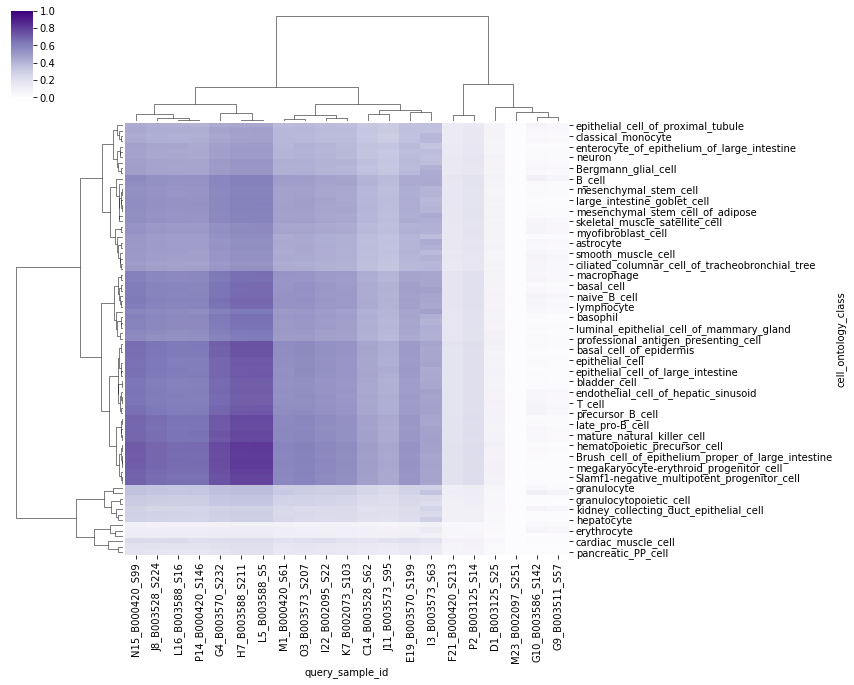

In [104]:
sns.clustermap(median_cell_ontology_yes_abundance, vmin=0, vmax=1, cmap='Purples')

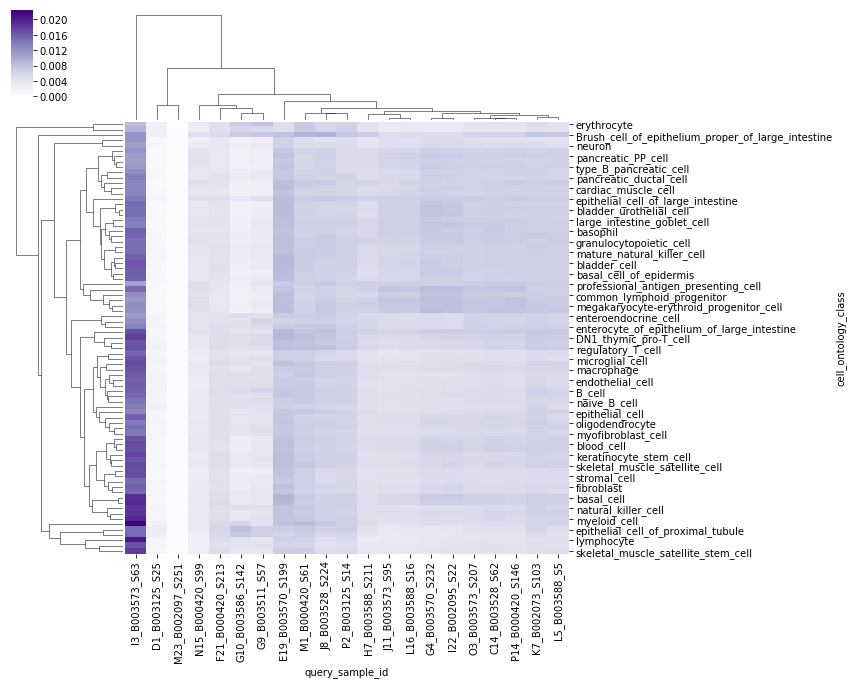

In [105]:
sns.clustermap(median_cell_ontology_no_abundance, vmin=0, cmap='Purples')

## Good cell, bad cell

### Good cell

`I3_B003573_S63` seems like a "good cell" that's similar to a lot of things. Let's look at its similarities.

In [107]:
good_cell = "I3_B003573_S63"

search_results_metadata.query('query_sample_id == @good_cell').groupby('ignore_abundance').apply(lambda x: x.head())

similarity  \
ignore_abundance                      
False            659088    0.565487   
                 659089    0.544368   
                 659090    0.543023   
                 659091    0.541401   
                 659092    0.541156   
True             695704    0.036008   
                 695705    0.035926   
                 695706    0.033177   
                 695707    0.033052   
                 695708    0.032999   

                                                                                                                                                         name  \
ignore_abundance                                                                                                                                                
False            659088         cell_ontology_class:macrophage|tissue:Brain_Myeloid|subtissue:Cerebellum|free_annotation:nan|cell_id:N16-MAA000605-3_10_M-1-1   
                 659089                                                                                                               A5-MAA001875-3_39_F-1-1   
                 659090  cell_ontology_class:epithelial_cell_of_proximal_tubule|tissue:Kidney|subtissue:nan|free_annotation:nan|cell_id:L3-B002775-3_39_F-1-1   
                 659091         cell_ontology_class:macrophage|tissue:Brain_Myeloid|subtissue:Cerebellum|free_annotation:nan|cell_id:C21-MAA000605-3_10_M-1-1   
                 659092         cell_ontology_class:macrophage|tissue:Brain_Myeloid|subtissue:Cerebellum|free_annotation:nan|cell_id:M18-MAA000605-3_10_M-1-1   
True             695704                        cell_ontology_class:myeloid_cell|tissue:Fat|subtissue:SCAT|free_annotation:nan|cell_id:M8-MAA000386-3_11_M-1-1   
                 695705                      cell_ontology_class:macrophage|tissue:Diaphragm|subtissue:nan|free_annotation:nan|cell_id:O10-B002762-3_39_F-1-1   
                 695706                        cell_ontology_class:myeloid_cell|tissue:Fat|subtissue:SCAT|free_annotation:nan|cell_id:O8-MAA000386-3_11_M-1-1   
                 695707                        cell_ontology_class:myeloid_cell|tissue:Fat|subtissue:BAT|free_annotation:nan|cell_id:B10-MAA000441-3_10_M-1-1   
                 695708     cell_ontology_class:microglial_cell|tissue:Brain_Myeloid|subtissue:Cerebellum|free_annotation:nan|cell_id:N21-MAA000570-3_8_M-1-1   

                                         filename  \
ignore_abundance                                    
False            659088  tabula-muris-k51-protein   
                 659089  tabula-muris-k51-protein   
                 659090  tabula-muris-k51-protein   
                 659091  tabula-muris-k51-protein   
                 659092  tabula-muris-k51-protein   
True             695704  tabula-muris-k51-protein   
                 695705  tabula-muris-k51-protein   
                 695706  tabula-muris-k51-protein   
                 695707  tabula-muris-k51-protein   
                 695708  tabula-muris-k51-protein   

                                                      md5 query_sample_id  \
ignore_abundance                                                            
False            659088  f74f9870c346941957c5189ea3835e6a  I3_B003573_S63   
                 659089  e6d87cc674c4ff973724ed3aa6844a81  I3_B003573_S63   
                 659090  2ec9624e564223b9386010cc1e36b75f  I3_B003573_S63   
                 659091  ebc4aa98941e91e6f9f8f2eaf200145c  I3_B003573_S63   
                 659092  e17c164f73001330fe1fd9f9a2553179  I3_B003573_S63   
True             695704  3f793c1c3a333db9ef786552e0547982  I3_B003573_S63   
                 695705  2c0737a2d3abe383c29ef1a37f730a06  I3_B003573_S63   
                 695706  8c75c9809a14aaed76ba125e94947324  I3_B003573_S63   
                 695707  b141ab9cd6282ff7498634be03d64873  I3_B003573_S63   
                 695708  4bb8e897bdcd6cee6fabe5b13669ca65  I3_B003573_S63   

                        ignore_abundance                   ce

In [108]:
compute_samples.query('id == @good_cell')

,id,read1,read2,name,output,trim_low_abundance_kmers,dna,protein,ksizes,scaled
2756,I3_B003573_S63,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/I3_B003573_S63/I3_B003573_S63_R1_001.fastq.gz,s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/I3_B003573_S63/I3_B003573_S63_R2_001.fastq.gz,I3_B003573_S63,s3://olgabot-maca/lung_cancer/sourmash_v4/I3_B003573_S63.signature,True,True,True,"21,27,33,51",1000


Let's look at its file size

In [110]:
! aws s3 ls --human-readable s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/$good_cell/

2018-05-18 18:41:06    7.3 MiB I3_B003573_S63_R1_001.fastq.gz
2018-05-18 18:41:08    7.5 MiB I3_B003573_S63_R2_001.fastq.gz


### Bad cell

`D1_B003125_S25` seems like a weird bad cell that's not similar to anything

In [53]:
bad_cell = "D1_B003125_S25"
search_results_metadata.query('query_sample_id == @bad_cell').head()

,similarity,name,filename,md5,query_sample_id,ignore_abundance,cell_id,cell_ontology_class,free_annotation,subtissue,tissue,cell_ontology_free_annotation
73232,0.316674,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:G16-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,7eaedc3ea86056aca4353152544cfff4,D1_B003125_S25,False,G16-MAA000914-3_9_M-1-1,T_cell,NaN,MAT,Fat,T_cell
73233,0.308141,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:E11-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,9c2251f947b9a9faf1cad898f2b1a0a1,D1_B003125_S25,False,E11-MAA000914-3_9_M-1-1,T_cell,NaN,MAT,Fat,T_cell
73234,0.307184,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:D12-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,942b9c25aed5b57d64572cdcbd8d3343,D1_B003125_S25,False,D12-MAA000914-3_9_M-1-1,T_cell,NaN,MAT,Fat,T_cell
73235,0.304018,cell_ontology_class:endothelial_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:D17-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,5e9de85eef4edef22566bb3eb1efc23b,D1_B003125_S25,False,D17-MAA000914-3_9_M-1-1,endothelial_cell,NaN,MAT,Fat,endothelial_cell
73236,0.302058,cell_ontology_class:T_cell|tissue:Fat|subtissue:MAT|free_annotation:nan|cell_id:H14-MAA000914-3_9_M-1-1,tabula-muris-k51-protein,2e4adc68cd4fd8e1c6119571c859ca71,D1_B003125_S25,False,H14-MAA000914-3_9_M-1-1,T_cell,NaN,MAT,Fat,T_cell


In [56]:
import os

s3_folder = os.path.dirname(compute_samples.query('id == @bad_cell').read1.iloc[0])
s3_folder

's3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/rawdata/D1_B003125_S25'

In [57]:
! aws s3 ls --human-readable $s3_folder/

2018-05-18 18:40:55    3.6 MiB D1_B003125_S25_R1_001.fastq.gz
2018-05-18 18:40:55    3.4 MiB D1_B003125_S25_R2_001.fastq.gz


WHOA that's really tiny. Maybe the "good cells" are really ones with deep sequencing?

In [58]:
median_cell_ontology = median_cell_ontology.sort_values(by=median_cell_ontology.columns.tolist(), ascending=False)
median_cell_ontology.head()

query_sample_id,L5_B003588_S5,H7_B003588_S211,G4_B003570_S232,N15_B000420_S99,J8_B003528_S224,P14_B000420_S146,L16_B003588_S16,O3_B003573_S207,M1_B000420_S61,I22_B002095_S22,...,E19_B003570_S199,I3_B003573_S63,C14_B003528_S62,J11_B003573_S95,P2_B003125_S14,F21_B000420_S213,D1_B003125_S25,G9_B003511_S57,G10_B003586_S142,M23_B002097_S251
cell_ontology_class,,,,,,,,,,,,,,,,,,,,,
pre-natural_killer_cell,0.359261,0.358039,0.342440,0.324177,0.313935,0.309144,0.308759,0.280069,0.274136,0.270214,...,0.250919,0.232139,0.231376,0.216160,0.111743,0.096867,0.038799,0.004435,0.004346,0.0
Slamf1-positive_multipotent_progenitor_cell,0.343052,0.342949,0.327808,0.310859,0.301527,0.297093,0.296095,0.269387,0.262834,0.257700,...,0.240250,0.216678,0.221753,0.207232,0.110523,0.095881,0.040508,0.006444,0.006216,0.0
immature_NK_T_cell,0.337716,0.337195,0.322403,0.308237,0.298142,0.294344,0.292616,0.266518,0.265229,0.255867,...,0.239111,0.238215,0.220936,0.206066,0.107730,0.093947,0.037146,0.009035,0.009218,0.0
mature_natural_killer_cell,0.318422,0.317098,0.305247,0.292745,0.283828,0.280052,0.278760,0.254893,0.254420,0.246248,...,0.229860,0.232574,0.212701,0.199265,0.103770,0.091092,0.037943,0.007908,0.008667,0.0
regulatory_T_cell,0.317090,0.316372,0.303332,0.293947,0.283443,0.280083,0.277902,0.253903,0.260202,0.245413,...,0.229303,0.242604,0.211718,0.198187,0.104409,0.092513,0.039050,0.014134,0.016799,0.0


## Seems like the read depth has to do with the similarity here

So let's read all the file sizes for `read1` of the sample id!

In [112]:
read1s = compute_samples.query('id in @search_results_metadata.query_sample_id').read1.unique()
# print(read1s)
for read1 in read1s:
    ! aws s3 ls --human-readable $read1

2018-05-18 18:37:38  177.2 MiB C14_B003528_S62_R1_001.fastq.gz
2018-05-18 18:40:55    3.6 MiB D1_B003125_S25_R1_001.fastq.gz
2018-05-18 18:26:08   48.1 MiB E19_B003570_S199_R1_001.fastq.gz
2018-05-18 18:54:14   15.7 MiB F21_B000420_S213_R1_001.fastq.gz
2018-05-18 18:57:30    3.5 MiB G10_B003586_S142_R1_001.fastq.gz
2018-05-18 18:34:57  121.6 MiB G4_B003570_S232_R1_001.fastq.gz
2018-05-18 18:54:29   11.9 MiB G9_B003511_S57_R1_001.fastq.gz
2018-05-18 18:58:25  184.6 MiB H7_B003588_S211_R1_001.fastq.gz
2018-05-18 18:46:05  111.9 MiB I22_B002095_S22_R1_001.fastq.gz
2018-05-18 18:41:06    7.3 MiB I3_B003573_S63_R1_001.fastq.gz
2018-05-18 18:41:30  217.0 MiB J11_B003573_S95_R1_001.fastq.gz
2018-05-18 18:56:36   76.6 MiB J8_B003528_S224_R1_001.fastq.gz
2018-05-18 19:02:25  133.3 MiB K7_B002073_S103_R1_001.fastq.gz
2018-05-18 19:00:04  267.4 MiB L16_B003588_S16_R1_001.fastq.gz
2018-05-18 19:01:51   84.3 MiB L5_B003588_S5_R1_001.fastq.gz
2018-05-18 19:01:41   34.8 MiB M1_B000420_S61_R1_001.fast

This time we'll do the same thing but save the output to a list called `lines`.

In [114]:
lines = []

for read1 in read1s:
    line = ! aws s3 ls $read1
    lines.append(line[0])

In [115]:
lines

['2018-05-18 18:37:38  185854171 C14_B003528_S62_R1_001.fastq.gz',
 '2018-05-18 18:40:55    3727319 D1_B003125_S25_R1_001.fastq.gz',
 '2018-05-18 18:26:08   50433901 E19_B003570_S199_R1_001.fastq.gz',
 '2018-05-18 18:54:14   16480016 F21_B000420_S213_R1_001.fastq.gz',
 '2018-05-18 18:57:30    3629973 G10_B003586_S142_R1_001.fastq.gz',
 '2018-05-18 18:34:57  127483386 G4_B003570_S232_R1_001.fastq.gz',
 '2018-05-18 18:54:29   12458701 G9_B003511_S57_R1_001.fastq.gz',
 '2018-05-18 18:58:25  193557449 H7_B003588_S211_R1_001.fastq.gz',
 '2018-05-18 18:46:05  117369098 I22_B002095_S22_R1_001.fastq.gz',
 '2018-05-18 18:41:06    7641874 I3_B003573_S63_R1_001.fastq.gz',
 '2018-05-18 18:41:30  227584576 J11_B003573_S95_R1_001.fastq.gz',
 '2018-05-18 18:56:36   80303430 J8_B003528_S224_R1_001.fastq.gz',
 '2018-05-18 19:02:25  139783039 K7_B002073_S103_R1_001.fastq.gz',
 '2018-05-18 19:00:04  280371146 L16_B003588_S16_R1_001.fastq.gz',
 '2018-05-18 19:01:51   88423984 L5_B003588_S5_R1_001.fastq.gz

In [116]:
read1_txt = '\n'.join(lines)

read1_txt

'2018-05-18 18:37:38  185854171 C14_B003528_S62_R1_001.fastq.gz\n2018-05-18 18:40:55    3727319 D1_B003125_S25_R1_001.fastq.gz\n2018-05-18 18:26:08   50433901 E19_B003570_S199_R1_001.fastq.gz\n2018-05-18 18:54:14   16480016 F21_B000420_S213_R1_001.fastq.gz\n2018-05-18 18:57:30    3629973 G10_B003586_S142_R1_001.fastq.gz\n2018-05-18 18:34:57  127483386 G4_B003570_S232_R1_001.fastq.gz\n2018-05-18 18:54:29   12458701 G9_B003511_S57_R1_001.fastq.gz\n2018-05-18 18:58:25  193557449 H7_B003588_S211_R1_001.fastq.gz\n2018-05-18 18:46:05  117369098 I22_B002095_S22_R1_001.fastq.gz\n2018-05-18 18:41:06    7641874 I3_B003573_S63_R1_001.fastq.gz\n2018-05-18 18:41:30  227584576 J11_B003573_S95_R1_001.fastq.gz\n2018-05-18 18:56:36   80303430 J8_B003528_S224_R1_001.fastq.gz\n2018-05-18 19:02:25  139783039 K7_B002073_S103_R1_001.fastq.gz\n2018-05-18 19:00:04  280371146 L16_B003588_S16_R1_001.fastq.gz\n2018-05-18 19:01:51   88423984 L5_B003588_S5_R1_001.fastq.gz\n2018-05-18 19:01:41   36450167 M1_B000420

To pretend that plain strings as "files" for pandas, we use `StringIO`.

In [122]:
from io import StringIO

read1_aws_s3_ls = pd.read_table(StringIO(read1_txt), delim_whitespace=True, header=None, 
                          names=['date', 'time', 'bytes', 'basename'])
read1_aws_s3_ls['sample_id'] = read1_aws_s3_ls['basename'].str.split('_R1').str[0]
read1_aws_s3_ls = read1_aws_s3_ls.set_index('sample_id')
read1_aws_s3_ls

,date,time,bytes,basename
sample_id,,,,
C14_B003528_S62,2018-05-18,18:37:38,185854171,C14_B003528_S62_R1_001.fastq.gz
D1_B003125_S25,2018-05-18,18:40:55,3727319,D1_B003125_S25_R1_001.fastq.gz
E19_B003570_S199,2018-05-18,18:26:08,50433901,E19_B003570_S199_R1_001.fastq.gz
F21_B000420_S213,2018-05-18,18:54:14,16480016,F21_B000420_S213_R1_001.fastq.gz
G10_B003586_S142,2018-05-18,18:57:30,3629973,G10_B003586_S142_R1_001.fastq.gz
G4_B003570_S232,2018-05-18,18:34:57,127483386,G4_B003570_S232_R1_001.fastq.gz
G9_B003511_S57,2018-05-18,18:54:29,12458701,G9_B003511_S57_R1_001.fastq.gz
H7_B003588_S211,2018-05-18,18:58:25,193557449,H7_B003588_S211_R1_001.fastq.gz
I22_B002095_S22,2018-05-18,18:46:05,117369098,I22_B002095_S22_R1_001.fastq.gz


In [123]:
read1_sizes = read1_aws_s3_ls['bytes']
read1_sizes = read1_sizes.sort_values()
read1_sizes

sample_id
M23_B002097_S251          150
G10_B003586_S142      3629973
D1_B003125_S25        3727319
I3_B003573_S63        7641874
G9_B003511_S57       12458701
F21_B000420_S213     16480016
M1_B000420_S61       36450167
E19_B003570_S199     50433901
P2_B003125_S14       61431977
J8_B003528_S224      80303430
L5_B003588_S5        88423984
I22_B002095_S22     117369098
G4_B003570_S232     127483386
K7_B002073_S103     139783039
O3_B003573_S207     153110411
C14_B003528_S62     185854171
H7_B003588_S211     193557449
J11_B003573_S95     227584576
P14_B000420_S146    255623110
L16_B003588_S16     280371146
N15_B000420_S99     449690564
Name: bytes, dtype: int64

## Now let's plot the similarity scores, ordered by the read1 sizes

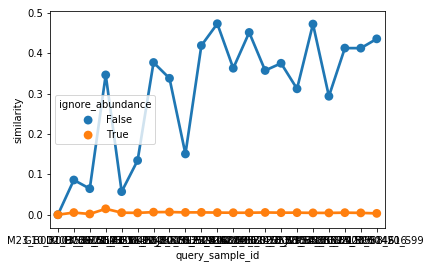

In [129]:
sns.pointplot(x='query_sample_id', y='similarity', hue='ignore_abundance',
              order=read1_sizes.index, data=search_results_metadata)

Definitely looks like there's a trend

/anaconda3/envs/bioinformagician/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


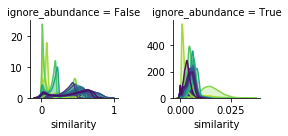

In [130]:
import seaborn as sns
%matplotlib inline

g = sns.FacetGrid(search_results, hue='query_sample_id', 
                  col='ignore_abundance', sharex=False, sharey=False,
                  hue_order=read1_sizes.index, palette='viridis_r', size=2)
g.map(sns.kdeplot, 'similarity', shade=True)
g.savefig('ashley_lung_cancer_similarity_distribution_per_cell_showing_seq_depth.pdf')

## Commit the changes in a branch so you can see them after your instance is gone

This is also helpful so you can just go to the github website for your branch and look at that for reference!

### To save your changes for the future, create a branch and commit your changes

Since you are saving the output to YOUR own bucket, you'll want to make sure you have the code that made these changes, and the best way to do that is to use `git`.

Create a branch named like this: `yourgithubsername/bioinformagician-part1`, e.g.:

```
git checkout -b olgabot/bioinformagician-part1
```

Add all the files in the `olgas_bioinformagician_tricks` folder:

```
cd ~/code/cupcakes/2018/
git add -A olgas_bioinformagician_tricks
```

Write a message about what files you're committing and why:

```
git commit -m "Use a s3 bucket I can write to"
```

Try to push the changes:

```
git push
```

Then you'll get a "fatal error" (but really nobody died so why the freakout?) that looks like this:


```
fatal: The current branch olgabot/enable_quality_filtering has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin olgabot/enable_quality_filtering
```


Copy/paste THEIR `git push` command which will properly link up your own branch name with the remote branch name on GitHub. (This is what I always do... I'm too lazy to write out the full command myself)

[Check out your branch in the whole tree here!](https://github.com/czbiohub/cupcakes/network)